In [1]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("./data/preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("./data/preprocessed_pes_with_energy.parquet")

In [2]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)



feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit', "outage"])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

### __Wind Energy Forecast__

__baseline__

In [4]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_wind\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_wind\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.30000000000000004 from qr_model_wind\qr_model_quantile_0.30000000000000004.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_wind\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_wind\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_wind\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7000000000000001 from qr_model_wind\qr_model_quantile_0.7000000000000001.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_wind\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_wind\qr_model_quantile_0

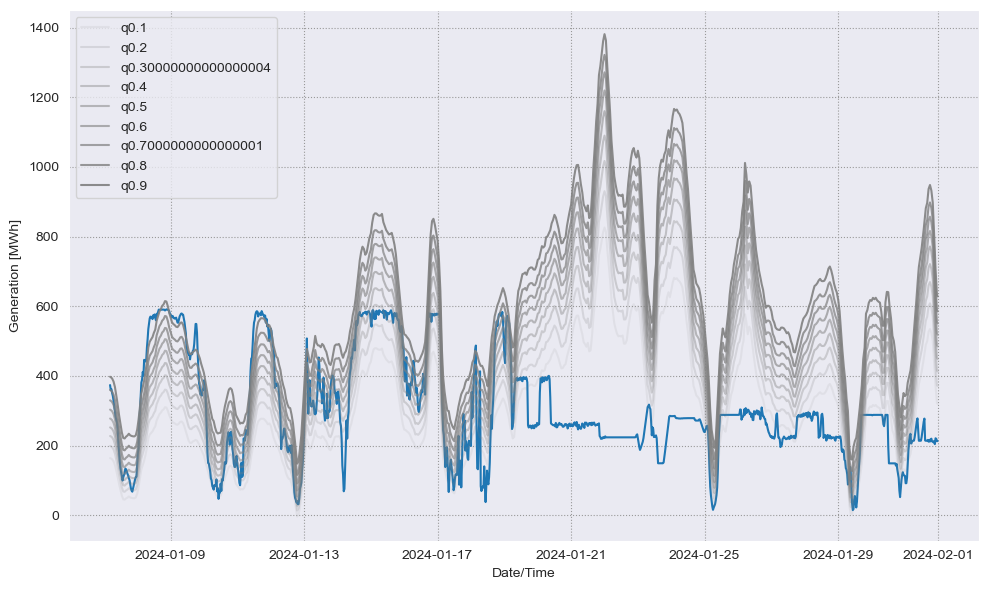

In [5]:
qr_model_wind.plot_quantils(feature_engineerer_wind_baseline.y_test, qr_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

__xgboost__

In [6]:
importlib.reload(model_utils)
import numpy as np

quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_wind"
hyperparams = {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": quantiles,
            "learning_rate": 0.01,
            "max_depth": 8
        }




xgboost_model_wind = model_utils.XGBoostModel(feature_engineerer_wind, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False, hyperparams=hyperparams, num_boost_round=45, early_stopping_rounds=10)
xgboost_model_wind.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_wind.pinball_score()}")

[0]	Train-quantile:98.07741	Val-quantile:90.10948
[1]	Train-quantile:97.02596	Val-quantile:89.30330
[2]	Train-quantile:95.98593	Val-quantile:88.51152
[3]	Train-quantile:94.95850	Val-quantile:87.72979
[4]	Train-quantile:93.94294	Val-quantile:86.95775
[5]	Train-quantile:92.94035	Val-quantile:86.19631
[6]	Train-quantile:91.94893	Val-quantile:85.44439
[7]	Train-quantile:90.96906	Val-quantile:84.70198
[8]	Train-quantile:89.99928	Val-quantile:83.96877
[9]	Train-quantile:89.04126	Val-quantile:83.24497
[10]	Train-quantile:88.09402	Val-quantile:82.53144
[11]	Train-quantile:87.15834	Val-quantile:81.83003
[12]	Train-quantile:86.23448	Val-quantile:81.14272
[13]	Train-quantile:85.31832	Val-quantile:80.45519
[14]	Train-quantile:84.41554	Val-quantile:79.78112
[15]	Train-quantile:83.52334	Val-quantile:79.11417
[16]	Train-quantile:82.63906	Val-quantile:78.45591
[17]	Train-quantile:81.76540	Val-quantile:77.80409
[18]	Train-quantile:80.90267	Val-quantile:77.16226
[19]	Train-quantile:80.04857	Val-quantile

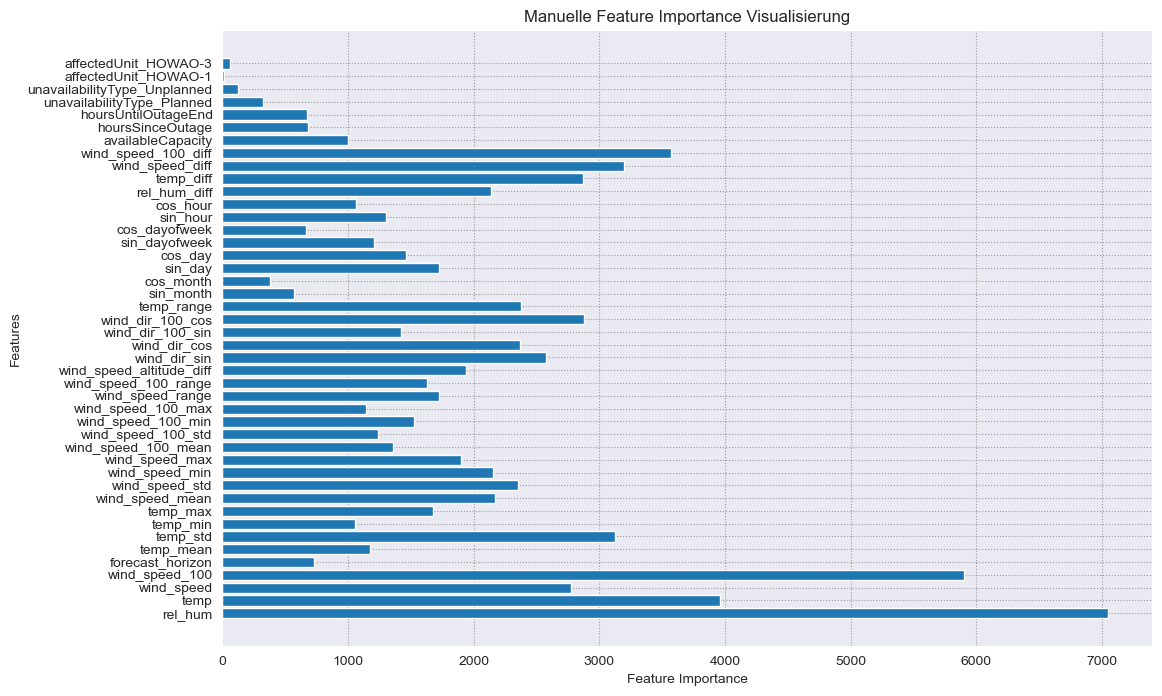

In [7]:
xgboost_model_wind.plot_feature_importance()

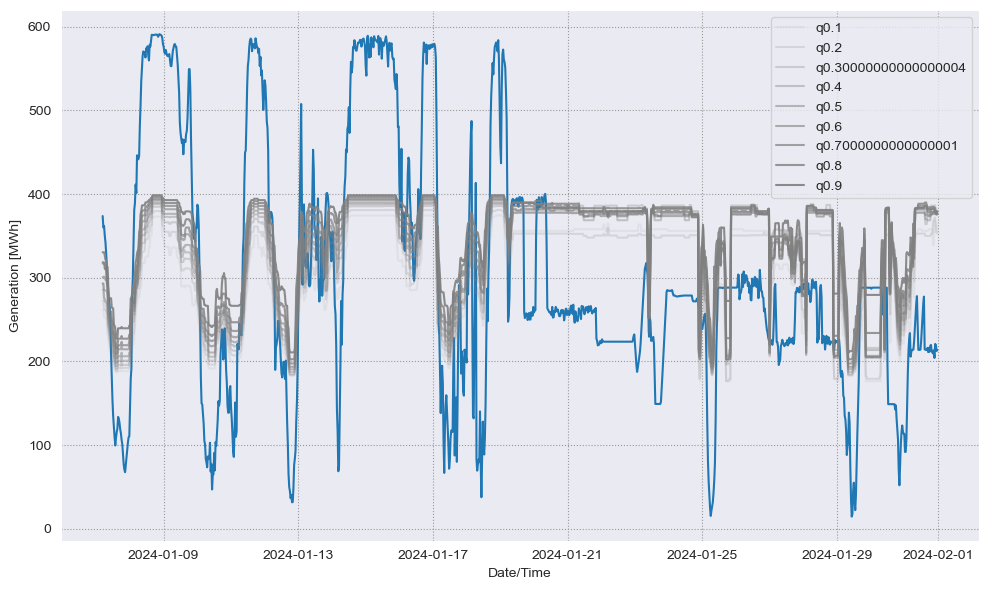

In [8]:
xgboost_model_wind.plot_quantils(x=feature_engineerer_wind.y_test, y=xgboost_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

### __Solar Energy Forecast__

__baseline modell__

In [9]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_solar\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_solar\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.30000000000000004 from qr_model_solar\qr_model_quantile_0.30000000000000004.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_solar\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_solar\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_solar\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7000000000000001 from qr_model_solar\qr_model_quantile_0.7000000000000001.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_solar\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_solar\qr_model_q

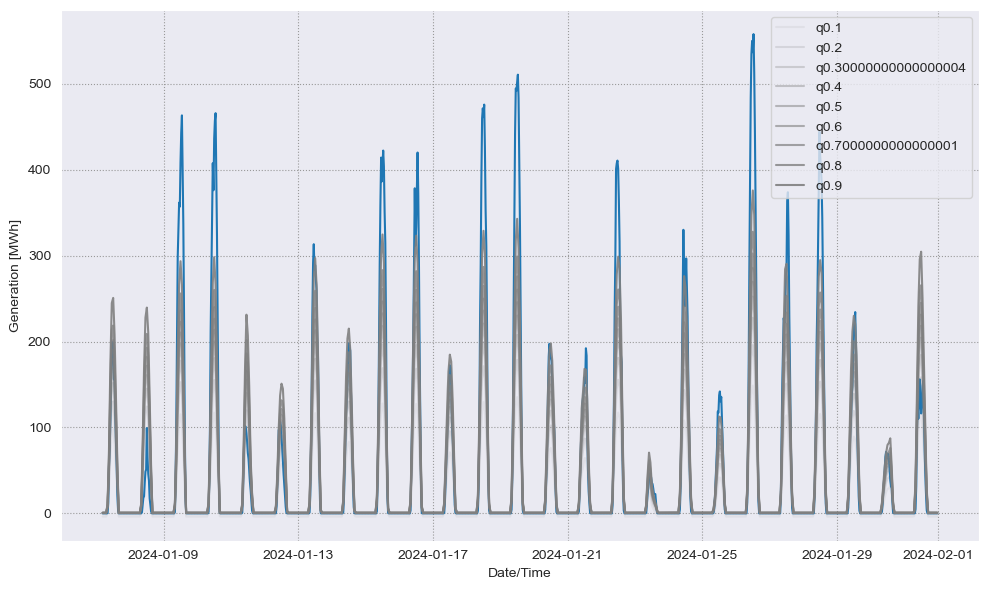

In [10]:
qr_model_solar.plot_quantils(x=feature_engineerer_solar_baseline.y_test, y=qr_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

__xgboost__

In [11]:
quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_solar"

xgboost_model_solar = model_utils.XGBoostModel(feature_engineerer_solar, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False)
xgboost_model_solar.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_solar.pinball_score()}")

[0]	Train-quantile:44.12934	Val-quantile:92.45040
[1]	Train-quantile:42.25378	Val-quantile:88.23022
[2]	Train-quantile:40.49921	Val-quantile:84.26820
[3]	Train-quantile:38.83767	Val-quantile:80.40501
[4]	Train-quantile:37.25540	Val-quantile:76.75663
[5]	Train-quantile:35.74075	Val-quantile:73.23852
[6]	Train-quantile:34.29832	Val-quantile:69.90319
[7]	Train-quantile:32.92390	Val-quantile:66.75642
[8]	Train-quantile:31.61632	Val-quantile:63.70747
[9]	Train-quantile:30.36195	Val-quantile:60.83232
[10]	Train-quantile:29.17036	Val-quantile:58.16254
[11]	Train-quantile:28.02325	Val-quantile:55.62580
[12]	Train-quantile:26.93823	Val-quantile:53.19340
[13]	Train-quantile:25.90241	Val-quantile:50.87963
[14]	Train-quantile:24.91697	Val-quantile:48.65411
[15]	Train-quantile:23.98590	Val-quantile:46.56167
[16]	Train-quantile:23.09794	Val-quantile:44.59455
[17]	Train-quantile:22.24520	Val-quantile:42.70010
[18]	Train-quantile:21.43087	Val-quantile:40.92479
[19]	Train-quantile:20.65521	Val-quantile

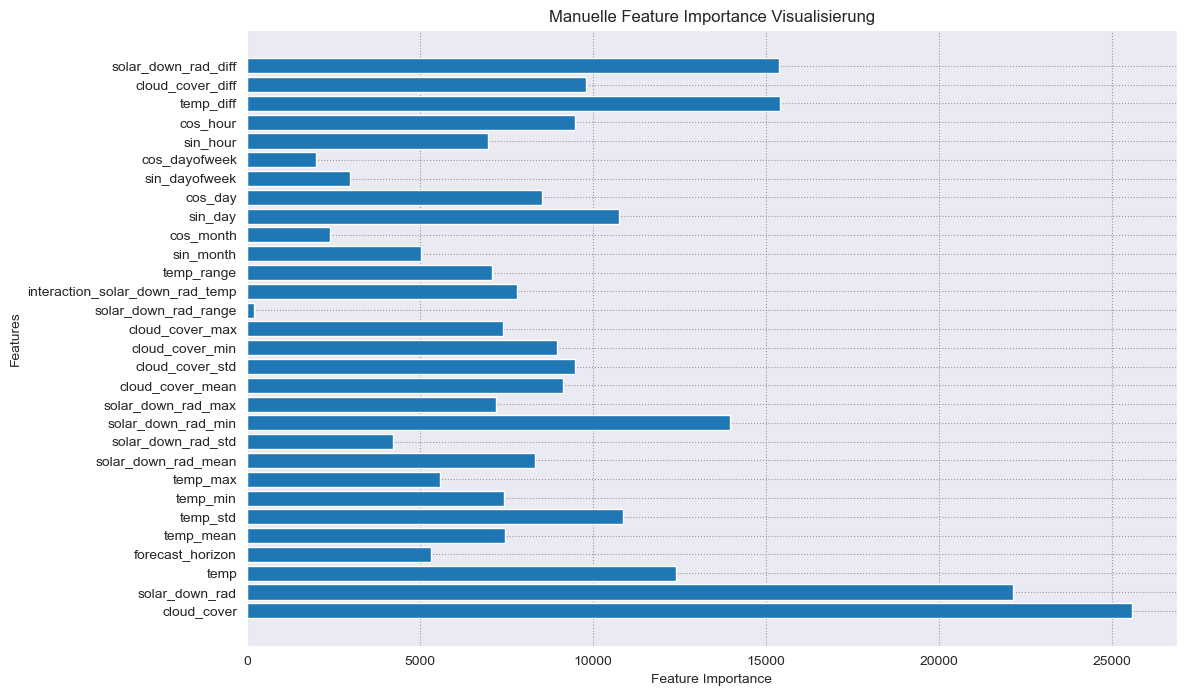

In [14]:
xgboost_model_solar.plot_feature_importance()

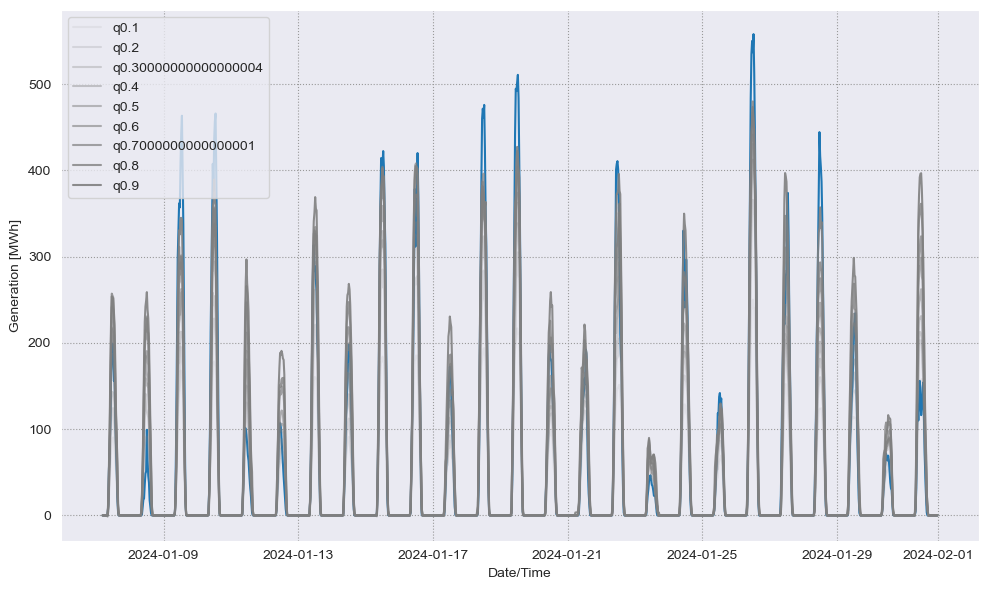

In [15]:
xgboost_model_solar.plot_quantils(x=feature_engineerer_solar.y_test, y=xgboost_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

### __Lightgbm implementation__

In [78]:
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind.pinball_score()}")

[LightGBM] [Info] Total Bins 8155
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 50
[LightGBM] [Info] Start training from score 9.724700
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 10.1477	valid's quantile: 15.3798
[100]	train's quantile: 9.3723	valid's quantile: 15.3115
[150]	train's quantile: 8.85279	valid's quantile: 15.2727
Early stopping, best iteration is:
[146]	train's quantile: 8.86304	valid's quantile: 15.2661
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_wind\qr_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 8155
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 50
[LightGBM] [Info] Start training from score 45.381004
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 14.462	valid's quantile: 21.0098
[100]	train's quantile: 13.6989	valid's quantile: 20.8239
Early stopping, best iteration is:
[89]	train

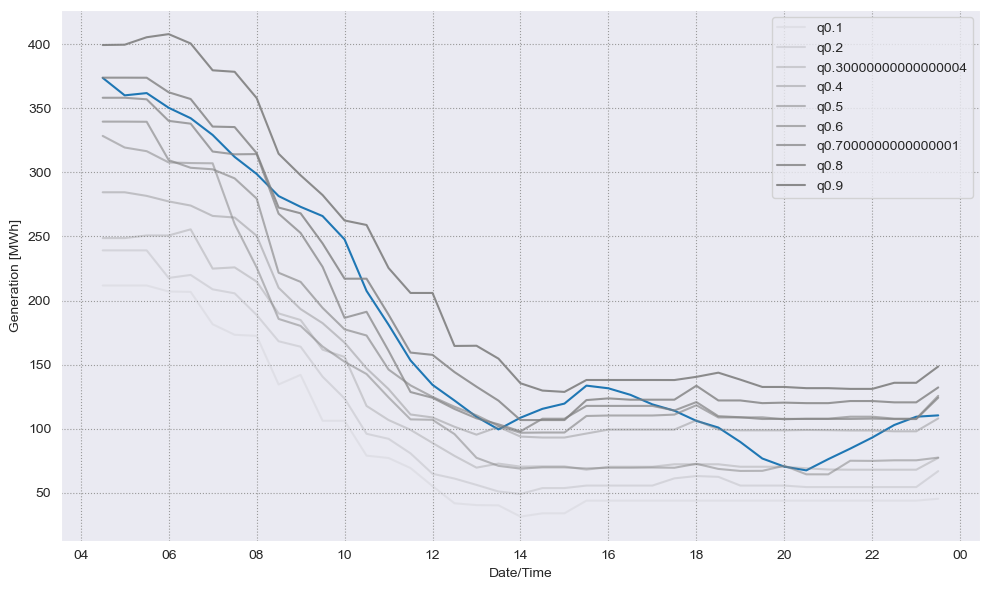

In [97]:
lgbm_model_wind.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind.q_predictions, quantiles, period="day", month=1 , day=7)

In [32]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar"

lgbm_model_solar = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar.pinball_score()}")

[LightGBM] [Info] Total Bins 5805
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 30
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 5.09227	valid's quantile: 5.36952
[100]	train's quantile: 4.39179	valid's quantile: 5.02654
[150]	train's quantile: 4.3137	valid's quantile: 4.9897
[200]	train's quantile: 4.2689	valid's quantile: 4.9739
[250]	train's quantile: 4.26053	valid's quantile: 4.97326
[300]	train's quantile: 4.25864	valid's quantile: 4.97093
Early stopping, best iteration is:
[296]	train's quantile: 4.25872	valid's quantile: 4.97074
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_solar\qr_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 5805
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 30
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 7.33284	valid's quantile: 8.31634
[100]	train's quantile: 6.40803	valid

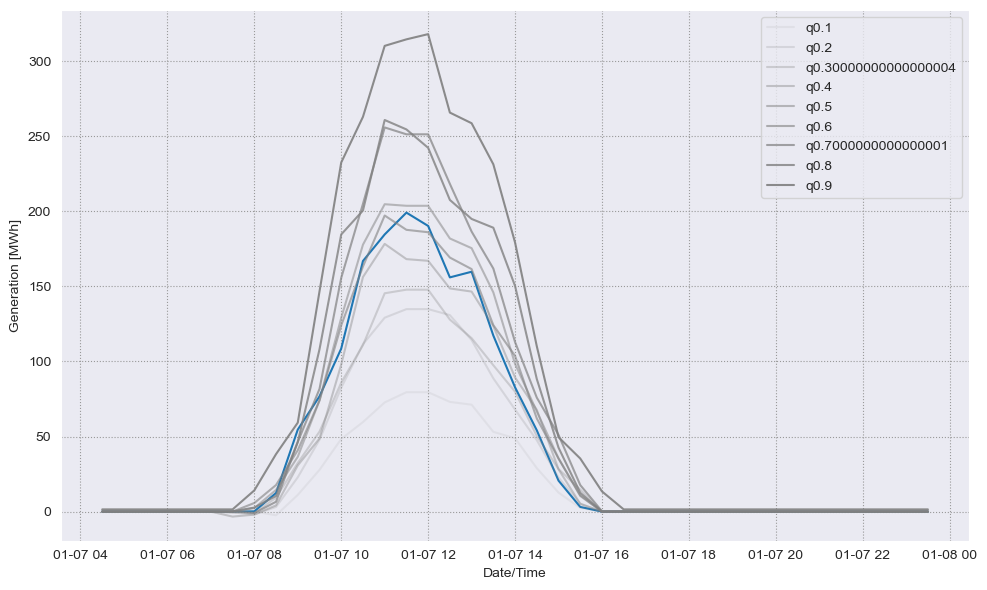

In [33]:
lgbm_model_solar.plot_quantils(feature_engineerer_solar.y_test, lgbm_model_solar.q_predictions, quantiles, period="day")

In [20]:
import neural_networks
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn
quantiles = np.arange(0.1, 1.0, 0.1)

nn_wind = neural_networks.Trainer(feature_engineerer_wind, neural_networks.q_model,quantiles)
nn_wind.train_and_test()

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 264.12445068359375
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 219.23287963867188
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 202.99832153320312
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 193.6880645751953
40. epoche startet: 
41. epoche startet: 
42. epoche st

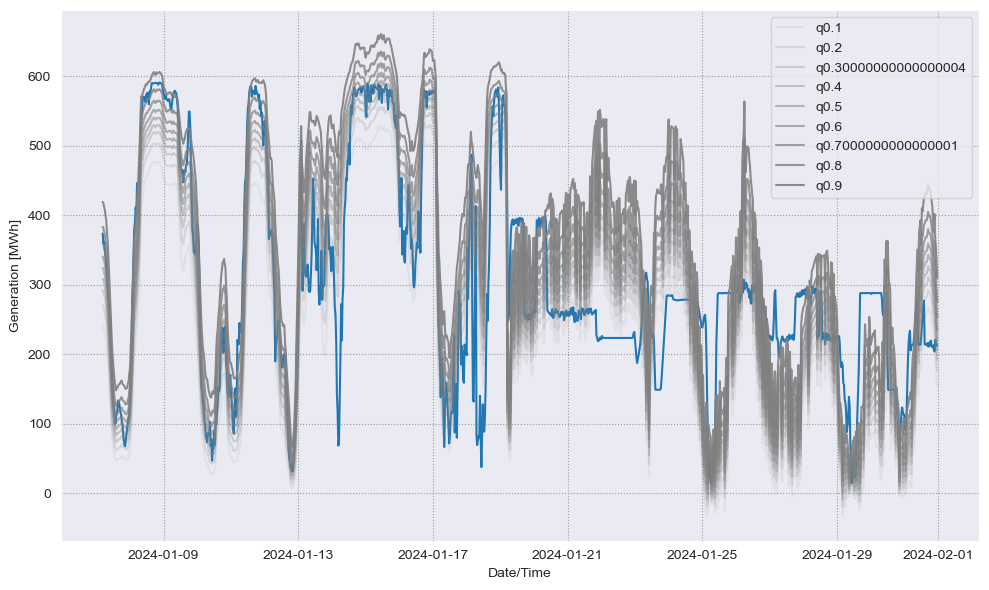

In [21]:
nn_wind.plot_quantils(feature_engineerer_wind.y_test, nn_wind.q_prediction_nn, quantiles)

In [22]:
import neural_networks
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn
quantiles = np.arange(0.1, 1.0, 0.1)

nn_solar = neural_networks.Trainer(feature_engineerer_solar, neural_networks.q_model, quantiles, in_shape=30)
nn_solar.train_and_test()

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 91.40584564208984
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 86.49214172363281
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 85.24822235107422
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 83.45191955566406
40. epoche startet: 
41. epoche startet: 
42. epoche start

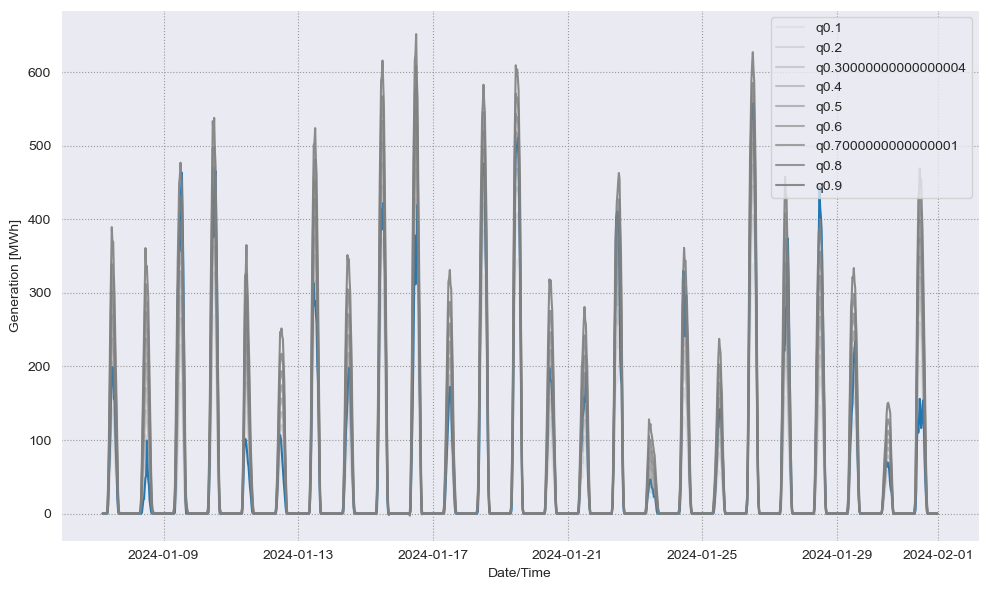

In [23]:
nn_solar.plot_quantils(feature_engineerer_solar.y_test, nn_solar.q_prediction_nn, quantiles)